# Aggregate proteomic data across studies

For best results, first run the [IdentifierUpdates_Proteomics](./IdentifierUpdates_Proteomics.ipynb) notebook first to remove old/obsolete accessions and map to current UniProt database. 
## Load protein table

Run the  notebook first to create the protein table.
Note: Requires internet connection to download information from the UniProt.

## Setup
### Import packages

In [1]:
from collections import defaultdict
import re
import pandas as pd

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


from rbc_gem_utils import (
    ROOT_PATH,
    DATABASE_PATH,
    EXTERNAL_PATH,
    ANNOTATION_PATH,
    INTERIM_PATH,
    check_version,
    check_database_version_online,
    show_versions,
    build_string,
)


from rbc_gem_utils.database.uniprot import (
    UNIPROT_ID_RE,
    UNIPROT_ISOFORM_ID_RE,
    UNIPROT_VERSION_EXPECTED,
    get_version_UniProt,
    query_UniProt,
    get_annotation_to_from_db_UniProt,
    get_label_miriam_mapping_UniProt,
    get_query_fields_UniProt,
    parse_isoforms_UniProt,
    parse_chains_UniProt,
    get_isoform_value_from_entry_UniProt,
)
# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
cobra      0.29.0
depinfo     2.2.0
matplotlib  3.8.2
memote     0.16.1
notebook    7.0.6
requests   2.31.0
scipy      1.11.4
seaborn    0.13.0

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
--------------------
Darwin  22.6.0-x86_64
CPython        3.12.0


## Check UniProt version
If the version does not match the expected version, it is because database has been updated since the last time this code was utilized. 

### Expected UniProt version: 2023_05
* According to [UniProt](https://www.uniprot.org/help/downloads), updates to the database are made every eight weeks. 
* Last release utilized: [2023_05](https://www.uniprot.org/uniprotkb/statistics) published on **Wed Nov 08 2023**.

In [2]:
if not check_database_version_online("UniProt"):
    warn("Online version of database has been updated since the last time notebook was used.")

version = get_version_UniProt()
if check_version(version, UNIPROT_VERSION_EXPECTED, verbose=True):
    database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
else:
     # Use different directory paths for unexpected behavior
    database_dirpath = f"{ROOT_PATH}{INTERIM_PATH}" 
    annotation_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"

Current and expected versions match.


## Load aggregated proteomic data, updated IDs

In [3]:
excel_filepath_processed = f"{ROOT_PATH}{EXTERNAL_PATH}/proteomics/proteomics_aggregated.xlsx"

### Load table of contents

In [4]:
df_contents = pd.read_excel(
    excel_filepath_processed,
    sheet_name="Table of Contents",
    dtype=str
).fillna("")
df_contents

,PubMed/Sheet Name,ID type,Year,Publication,Notes
0,16861337,UniProt,2006,"Pasini EM, Kirkegaard M, Mortensen P, Lutz HU,...",590 IPI;438 UniProt;147 Obsolete --> 441 UniP...
1,18399644,UniProt,2008,"Simó C, Bachi A, Cattaneo A, Guerrier L, Forti...",153 IPI;135 UniProt;18 Obsolete --> 136 UniPr...
2,18494517,UniProt,2008,"Ringrose JH, van Solinge WW, Mohammed S, O'Fla...",699 IPI;400 UniProt;299 Obsolete --> 400 UniP...
3,18614565,UniProt,2008,"Roux-Dalvai F, Gonzalez de Peredo A, Simó C, G...",1577 IPI;1318 UniProt;256 Obsolete --> 1321 U...
4,19778645,UniProt,2009,"van Gestel RA, van Solinge WW, van der Toorn H...",561 GI;473 UniProt;138 Obsolete --> 473 UniPr...
5,22954596,UniProt,2012,"Pesciotta EN, Sriswasdi S, Tang HY, Mason PJ, ...",831 UniProt --> 766 UniProt 2023_05
6,24555563,UniProt,2014,"Lange PF, Huesgen PF, Nguyen K, Overall CM. An...",1220 UniProt --> 1214 UniProt 2023_05
7,26078478,UniProt,2015,"Hegedűs T, Chaubey PM, Várady G, Szabó E, Sara...",419 UniProt --> 416 UniProt 2023_05
8,26474164,UniProt,2015,"Pesciotta EN, Lam HS, Kossenkov A, Ge J, Showe...",1245 UniProt --> 1148 UniProt 2023_05
9,27006477,UniProt,2016,"Wilson MC, Trakarnsanga K, Heesom KJ, Cogan N,...",1314 UniProt --> 1187 UniProt 2023_05


### Aggregate proteins into table

In [5]:
index_name = "Uniprot"
df_proteins_aggregated = pd.DataFrame([], columns=[index_name])
for _, (sheet_name, id_type) in df_contents[["PubMed/Sheet Name", "ID type"]].iterrows():
    if id_type != "UniProt":
        warn("Can only utilize UniProt IDs for final aggregation")
        continue
    df = pd.read_excel(excel_filepath_processed, sheet_name=sheet_name, usecols=[0])
    df.columns = [sheet_name]
    df[index_name] = df[sheet_name]
    df_proteins_aggregated = df_proteins_aggregated.merge(df, left_on=index_name, right_on=index_name, how="outer")
df_proteins_aggregated = df_proteins_aggregated.drop_duplicates().set_index(index_name).notna()
df_proteins_aggregated.columns.name = "pubmed"
df_unreviewed_proteins = df_proteins_aggregated.copy()
df_unreviewed_proteins

pubmed,16861337,18399644,18494517,18614565,19778645,22954596,24555563,26078478,26474164,27006477,28263177,28689405,30327373,31552303,33103907,33341364,35858567,36346805,37760001,37942280
Uniprot,,,,,,,,,,,,,,,,,,,,
A0FGR8,True,False,False,False,True,True,False,True,False,True,True,False,True,False,False,False,True,False,False,False
A0PJE2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
A6NDU8,True,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False
A6NH11,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
O00161,True,False,False,False,False,True,True,True,False,True,True,True,True,True,False,True,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y446,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
Q9Y4P3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
Q9Y4W2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


### Query UniProt, keep reviewed proteins

In [6]:
# Extract all relevant information for now and save
query_parameters = {
    "query": " && ".join([
        "(reviewed:true)",
        "(organism_id:9606)", # Homo sapiens (Human)
    ]),
    "format": "tsv",
    "size": 500,
    "compressed": True,
    "fields": ",".join([
        "reviewed",
        "accession",
        "gene_primary",
    ])
}

df_results, uniparc, failed_ids, obselete_counts = query_UniProt(
    list(df_unreviewed_proteins.index), 
    query_parameters=query_parameters,
    from_db="UniProtKB",
    to_db="UniProtKB",
    return_failed=True
)

df_results = df_results[df_results["Reviewed"] == "reviewed"].drop_duplicates()
df_results

Fetched: 500 / 4297
Fetched: 1000 / 4297
Fetched: 1500 / 4297
Fetched: 2000 / 4297
Fetched: 2500 / 4297
Fetched: 3000 / 4297
Fetched: 3500 / 4297
Fetched: 4000 / 4297


Number of failed query IDs : 1159


Fetched: 4297 / 4297


,From,Reviewed,Entry,Gene Names (primary)
0,A0A075B6H9,reviewed,A0A075B6H9,IGLV4-69
1,A0A075B6S5,reviewed,A0A075B6S5,IGKV1-27
2,A0A087WSY6,reviewed,A0A087WSY6,IGKV3D-15
3,A0A0A0MRZ8,reviewed,A0A0A0MRZ8,IGKV3D-11
4,A0A0A0MS15,reviewed,A0A0A0MS15,IGHV3-49
...,...,...,...,...
4292,Q9Y6U3,reviewed,Q9Y6U3,SCIN
4293,Q9Y6V0,reviewed,Q9Y6V0,PCLO
4294,Q9Y6W5,reviewed,Q9Y6W5,WASF2
4295,Q9Y6X8,reviewed,Q9Y6X8,ZHX2


In [7]:
df_reviewed_proteins = df_unreviewed_proteins.loc[df_results["Entry"].values]
df_reviewed_proteins = df_reviewed_proteins.astype(int)
df_reviewed_proteins = df_reviewed_proteins.loc[
    df_reviewed_proteins.sum(axis=1).sort_values(ascending=False).index.values
]
df_reviewed_proteins

pubmed,16861337,18399644,18494517,18614565,19778645,22954596,24555563,26078478,26474164,27006477,28263177,28689405,30327373,31552303,33103907,33341364,35858567,36346805,37760001,37942280
Uniprot,,,,,,,,,,,,,,,,,,,,
P04406,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1
P04040,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1
P51148,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Q99832,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1
P53396,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8TF65,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Q8TEY5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Q8TES7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Export protein table

In [8]:
df_reviewed_proteins.to_csv(
    f"{ROOT_PATH}{EXTERNAL_PATH}/proteomics/proteomic_evidence_table.tsv",
    sep="\t"
)

### Visualize Protein Table

In [9]:
df_figure_data = pd.read_csv(
    f"{ROOT_PATH}{EXTERNAL_PATH}/proteomics/proteomic_evidence_table.tsv",
    sep="\t",
    index_col=0,
)
df_figure_data.columns.name = "pubmed"
# Order by number of proteins detected in a single study
pubmed_ids_ordered = df_figure_data.sum(axis=0).sort_values(ascending=False).index.values
df_figure_data = df_figure_data.loc[:, pubmed_ids_ordered]

# Order by umber of times a single  protein was detected across studies
protein_ids_ordered = df_figure_data.sum(axis=1).sort_values(ascending=False).index.values
df_figure_data = df_figure_data.loc[protein_ids_ordered, :]

# Transport for figure
df_figure_data = df_figure_data.T
df_figure_data

Uniprot,P04406,P51148,Q99832,P04040,P49720,P00387,P11142,P52907,P02549,P50991,...,Q9UMR2,Q9UI30,Q9UI42,O60641,O60518,Q9UIG0,Q9UMN6,O60486,Q9UIJ7,A0A075B6H9
pubmed,,,,,,,,,,,,,,,,,,,,,
28689405,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
30327373,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
28263177,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
37942280,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,1,0,0,0,0
35858567,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,0
18614565,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
24555563,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
27006477,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,0
33103907,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,1


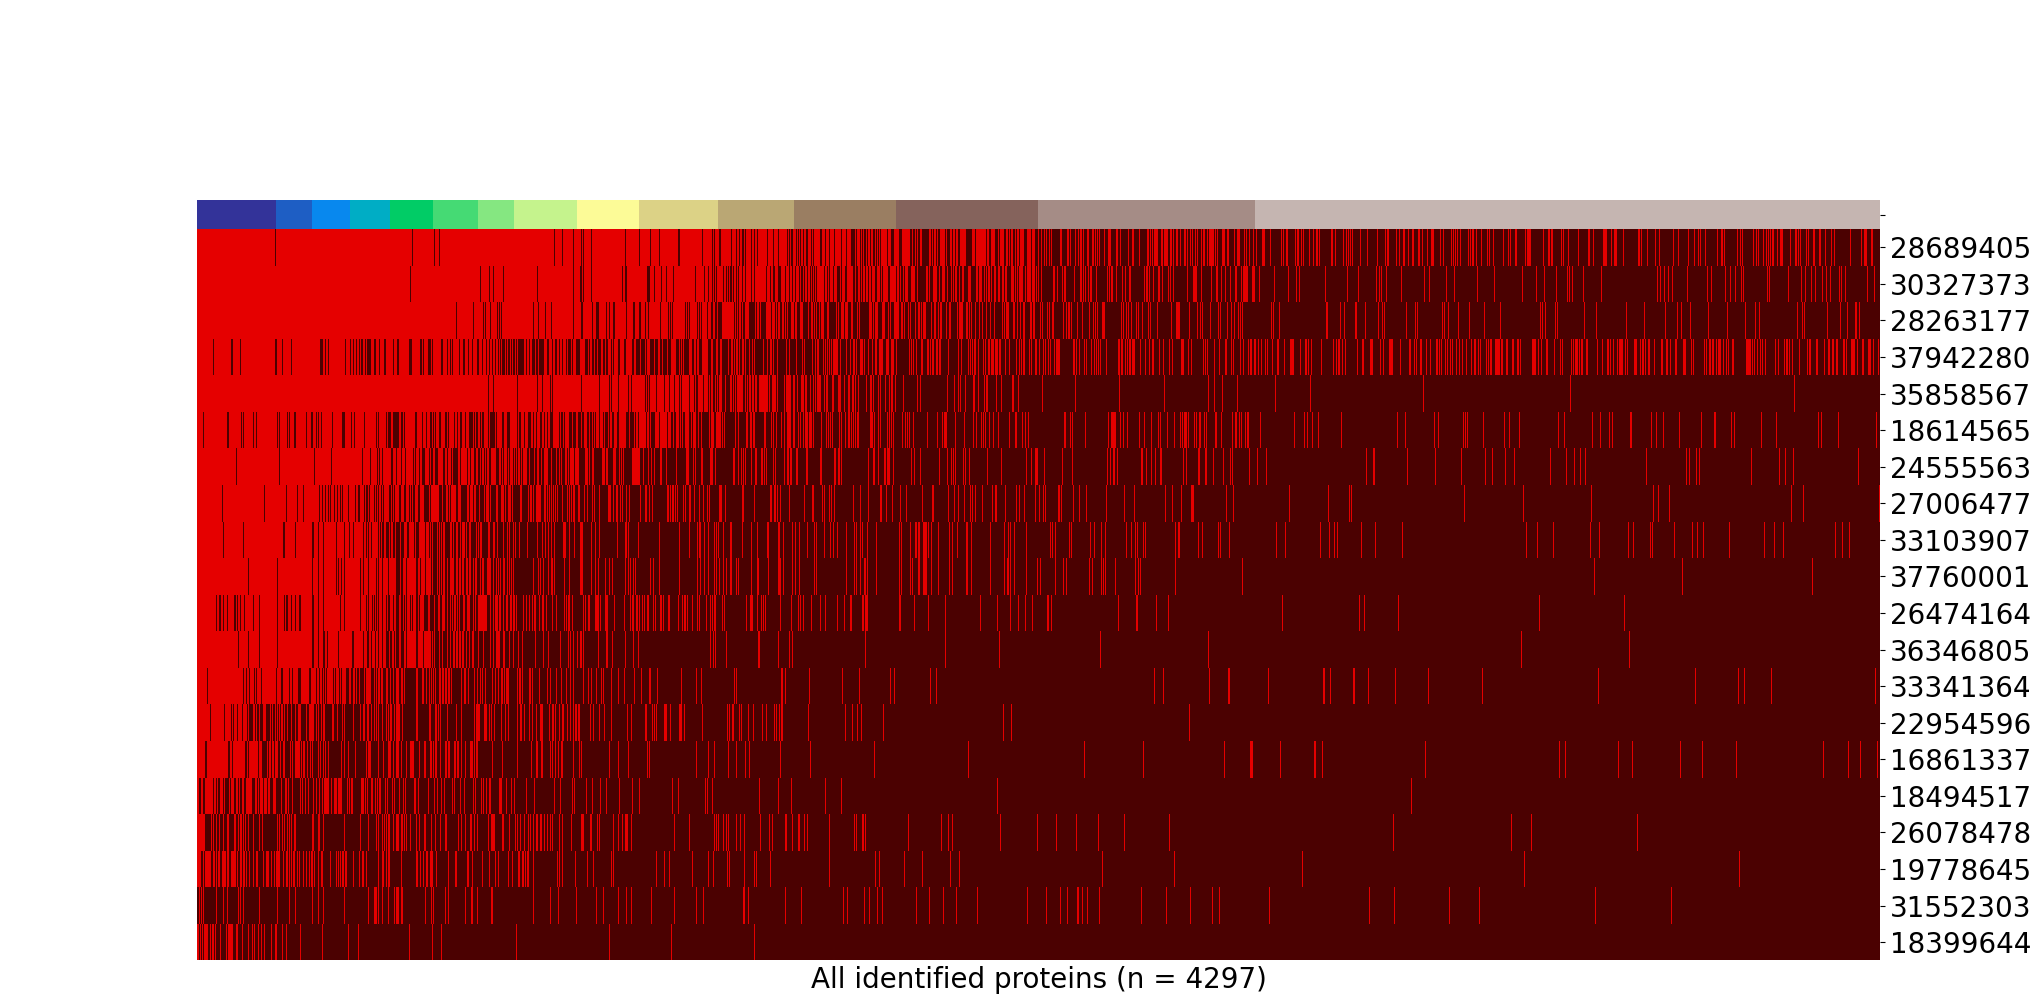

In [10]:
max_pub_count = 15

df_counts_cmap = df_figure_data.sum()
max_val = df_counts_cmap.max()
cmap = mpl.colormaps.get_cmap("terrain_r")

cmin, cmax = (0.05, 1)
cmap_dict = dict(zip(
    list(range(max_pub_count + 1)), 
    cmap(np.linspace(cmin, cmax, max_pub_count + 1))
))

cmap_dict.update({
    k: cmap_dict[max_pub_count]
    for k in list(range(max_val + 1))
    if k not in cmap_dict
})
df_counts_cmap = df_counts_cmap.apply(lambda x: cmap_dict[x])

fig_heatmap = sns.clustermap(
    df_figure_data,
    figsize=(20, 10),
    row_cluster=False,
    col_cluster=False,
    cbar_pos=None,
    dendrogram_ratio=(.1, .2),
    col_colors=df_counts_cmap,
    cmap=mpl.colors.ListedColormap(["xkcd:dried blood", "xkcd:red"]),
    xticklabels=False,
)

ax = plt.gca()
ax.set_xlabel(f"All identified proteins (n = {len(df_figure_data.columns)})", fontsize=20)
ax.set_ylabel(None)
ax.yaxis.tick_right()
ax.tick_params(axis='y', labelsize=20)
fig_heatmap;

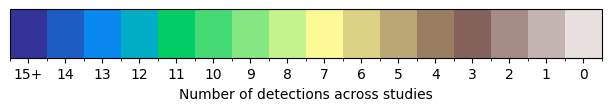

In [11]:
# Colorbar
fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')
cmap = mpl.colormaps.get_cmap("terrain_r")
cmap_colorbar= dict(zip(
    list(range(max_pub_count + 1)), 
    cmap(np.linspace(cmax, cmin, max_pub_count + 1))
))
labels = [f"{str(x)}+" if x == max_pub_count else str(x) for x in cmap_colorbar.keys()]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'compare',
    list(cmap_colorbar.values()), 
    max_pub_count + 1
)
norm = mpl.colors.BoundaryNorm(np.linspace(0, max_pub_count + 1, max_pub_count + 2), cmap.N)

colorbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax,
    orientation='horizontal',
    label="Number of detections across studies",
)

values = list(cmap_colorbar.keys())
values.reverse()
colorbar.set_ticks(list(np.array(values) + 0.5), labels=labels)
colorbar